# Capstone Project: Board Games Recommender
____________

# Part 1b - EDA & Cleaning of User Ratings

### Riche Ngo, SG-DSI-18

### Contents:
- [User Ratings](#User-Ratings)

In [25]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json_lines
import json
import ijson
import pickle
import urllib

# Images
import cv2

from sqlalchemy import create_engine

### Import data

Import the data for ratings by users of the BGG community.

In [2]:
# User ratings on board games
# Read 10 lines of the .jl file to see what we are dealing with
with open('../datasets/boardgames/bgg_RatingItem.jl', 'rb') as f:
    count = 1
    for item in json_lines.reader(f):
        print(count, item)
        print('\n-----------------------')
        count += 1
        if count == 10:
            break

1 {'bgg_id': 13, 'bgg_user_for_trade': False, 'bgg_user_name': ' beastvol', 'bgg_user_owned': True, 'bgg_user_play_count': 0, 'bgg_user_preordered': False, 'bgg_user_prev_owned': False, 'bgg_user_rating': 8.0, 'bgg_user_want_in_trade': False, 'bgg_user_want_to_buy': False, 'bgg_user_want_to_play': False, 'item_id': '4301111', 'updated_at': '2007-01-05T16:27:08+0000'}

-----------------------
2 {'bgg_id': 118, 'bgg_user_for_trade': False, 'bgg_user_name': ' beastvol', 'bgg_user_owned': True, 'bgg_user_play_count': 0, 'bgg_user_preordered': False, 'bgg_user_prev_owned': False, 'bgg_user_rating': 7.0, 'bgg_user_want_in_trade': False, 'bgg_user_want_to_buy': False, 'bgg_user_want_to_play': False, 'item_id': '5886861', 'updated_at': '2007-12-18T23:16:15+0000'}

-----------------------
3 {'bgg_id': 278, 'bgg_user_for_trade': False, 'bgg_user_name': ' beastvol', 'bgg_user_owned': True, 'bgg_user_play_count': 0, 'bgg_user_preordered': False, 'bgg_user_prev_owned': False, 'bgg_user_rating': 7.0

In [3]:
# User profiles on BGG
# Read 10 lines of the .jl file to see what we are dealing with
with open('../datasets/boardgames/scraped_bgg_UserItem.jl', 'rb') as f:
    count = 1
    for item in json_lines.reader(f):
        print(count, item)
        print('\n-----------------------')
        count += 1
        if count == 10:
            break

1 {'bgg_user_name': ' beastvol', 'country': 'United States', 'first_name': 'Ben', 'item_id': 93730, 'last_login': '2008-01-05T00:00:00+0000', 'last_name': 'Eastvold', 'region': 'California', 'registered': 2006, 'updated_at': '2021-01-02T21:41:11+0000'}

-----------------------
2 {'bgg_user_name': ' fu_koios ', 'country': 'United States', 'first_name': 'Daniel', 'item_id': 131428, 'last_login': '2020-12-23T00:00:00+0000', 'last_name': 'Reece', 'region': 'Ohio', 'registered': 2007, 'updated_at': '2020-12-25T22:06:03+0000'}

-----------------------
3 {'bgg_user_name': ' mycroft', 'country': 'United States', 'first_name': 'Ron', 'item_id': 72411, 'last_login': '2020-02-22T00:00:00+0000', 'last_name': 'Stewart', 'region': 'New Mexico', 'registered': 2005, 'updated_at': '2020-12-28T00:11:05+0000'}

-----------------------
4 {'bgg_user_name': ' woh', 'country': 'Belgium', 'first_name': 'w', 'item_id': 117522, 'last_login': '2019-02-05T00:00:00+0000', 'last_name': 'o', 'registered': 2006, 'upd

We want to import the data containing the user ratings since it would come in useful for recommender systems using collaborating filtering. We choose not to use the user profiles.

In [1]:
# Count the number of lines in large json_lines file
with open('../datasets/boardgames/bgg_RatingItem.jl', 'rb') as f:
    count_lines = sum([1 for line in f])
count_lines

38968809

In [16]:
# Import user ratings into dataframe
# Extract only the ratings from 2015 onwards
data = []
with open('../datasets/boardgames/bgg_RatingItem.jl', 'rb') as f:
    
    for item in json_lines.reader(f):
        user_dict = {}
        try:
            year = int(item['updated_at'].split('-')[0])
            month = int(item['updated_at'].split('-')[1])
            if year >= 2015:
                user_dict['bgg_user_name'] = item['bgg_user_name']
                user_dict['bgg_id'] = item['bgg_id']
                user_dict['bgg_user_rating'] = item['bgg_user_rating']
                user_dict['year'] = year
                user_dict['month'] = month
                data.append(user_dict)
        except:
            continue

In [17]:
user_df = pd.DataFrame(data)

In [24]:
user_df.sample(10, random_state=42)

,bgg_user_name,bgg_id,bgg_user_rating,year,month
9241479,robanders8,108784,10.0,2015,7
2378463,danielsp_86,39351,8.0,2015,6
8722111,prof. plum,826,10.0,2020,9
1795305,chaimw,277961,6.0,2019,5
2472087,dattenhein,171668,8.0,2019,5
4460241,haschim,177524,6.0,2019,9
11081153,tms_,45,7.5,2019,2
7987428,novatheorem,193557,7.0,2017,3
7178516,mhoehener,219513,8.0,2019,8
5994116,kmancheese,163354,5.0,2015,4


In [18]:
user_df.shape

(12278239, 5)

In [32]:
user_df.dtypes

bgg_user_name       object
bgg_id               int64
bgg_user_rating    float64
year                 int64
month                int64
dtype: object

In [61]:
# Check for null values
user_df.isnull().sum()

bgg_user_name      0
bgg_id             0
bgg_user_rating    0
year               0
month              0
dtype: int64

## User Ratings

In [31]:
user_df['bgg_user_rating'].describe()

count    1.227824e+07
mean     7.133654e+00
std      1.587553e+00
min      1.000000e-03
25%      6.000000e+00
50%      7.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: bgg_user_rating, dtype: float64

We observe that the median rating is 7.0, and most of the users gave board games a rating of between 6.0 and 8.0 (inclusive).

We noticed that the minimum rating is 0.001 which is not possible. We will remove those rows.

In [51]:
# Check those anomalous ratings
user_df[user_df['bgg_user_rating']<1]

,bgg_user_name,bgg_id,bgg_user_rating,year,month
826271,badgeguy,7971,0.001,2018,1
10166363,solid,18041,0.001,2019,5


In [52]:
# Remove anomalies
user_df = user_df[user_df['bgg_user_rating'] >= 1]

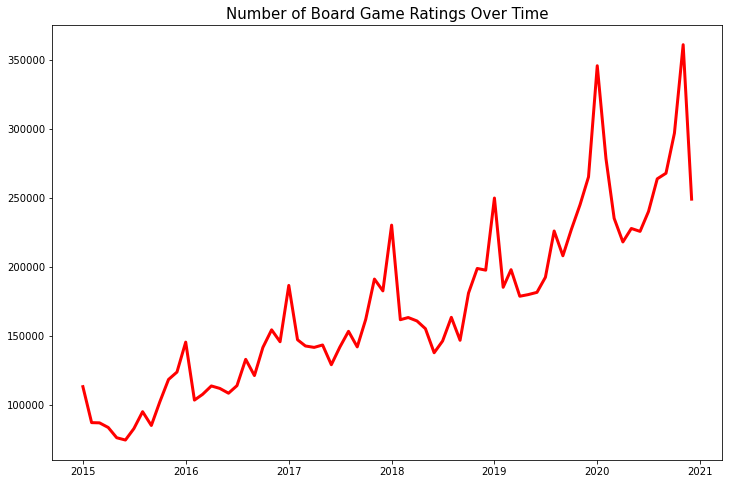

In [53]:
yr_plot = pd.to_datetime(user_df[['year', 'month']].assign(DAY=1)).value_counts().sort_index()

plt.figure(figsize=(12,8))
plt.plot(yr_plot.index, yr_plot.values, linewidth=3, c='r')
plt.title('Number of Board Game Ratings Over Time', fontsize=15);

We observe that there is a general increasing trend in the number of ratings given to board games throughout the years. There seems to be a cyclic pattern, where the number of ratings generally plunges towards the mid of each year, then rises quickly nearing the end of each year. The number of board games then drops down easing into a new year and the cycle repeats. It suggests that people are generally more active on the BGG website towards the end of each year, where more board games tend to be released. It is also common for online creators to post their reviews on board games every quarter of the year, leading to overall reviews on that particular year at the end. This increases the awareness of many board games in general, thereby increasing online activity. Furthermore, people are more likely to play board games towards the end of the year due to holidays and also more freetime. 

### Save file

In [54]:
# Save the dataframe as a .pkl file
outfile = open('../datasets/boardgames/bgg_5yrs_RatingItem.pkl', 'wb')
pickle.dump(user_df, outfile)
outfile.close()

In [62]:
# Create a local database using sqlite
engine = create_engine('sqlite:///../datasets/boardgames/bgg_5yrs_RatingItem.db', echo=True)
sqlite_connection = engine.connect()

2021-01-13 21:34:54,602 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-01-13 21:34:54,604 INFO sqlalchemy.engine.base.Engine ()
2021-01-13 21:34:54,606 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-01-13 21:34:54,607 INFO sqlalchemy.engine.base.Engine ()


In [63]:
# Save dataframe to database
sqlite_table = "bgg_ratings"
user_df.to_sql(sqlite_table, sqlite_connection, if_exists='fail', index=False)

2021-01-13 21:34:58,084 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("bgg_ratings")
2021-01-13 21:34:58,085 INFO sqlalchemy.engine.base.Engine ()
2021-01-13 21:34:58,087 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("bgg_ratings")
2021-01-13 21:34:58,087 INFO sqlalchemy.engine.base.Engine ()
2021-01-13 21:34:58,090 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE bgg_ratings (
	bgg_user_name TEXT, 
	bgg_id BIGINT, 
	bgg_user_rating FLOAT, 
	year BIGINT, 
	month BIGINT
)


2021-01-13 21:34:58,091 INFO sqlalchemy.engine.base.Engine ()
2021-01-13 21:34:58,098 INFO sqlalchemy.engine.base.Engine COMMIT
2021-01-13 21:35:00,825 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2021-01-13 21:35:54,872 INFO sqlalchemy.engine.base.Engine INSERT INTO bgg_ratings (bgg_user_name, bgg_id, bgg_user_rating, year, month) VALUES (?, ?, ?, ?, ?)
2021-01-13 21:35:54,877 INFO sqlalchemy.engine.base.Engine ((' fu_koios ', 223033, 9.0, 2017, 10), ('-=yod@=-', 7, 7.5, 2015, 3), ('-=

In [64]:
# Close connection
sqlite_connection.close()

In [21]:
# with open('../datasets/boardgames/scraped_bgg_UserItem.jl', 'rb') as f:
#     objects = ijson.items(f, 'bgg_user_name')
#     columns = list(objects)

# columns

In [ ]:

# filename = "md_traffic.json"
# with open(filename, 'r') as f:
#     objects = ijson.items(f, 'meta.view.columns.item')
#     columns = list(objects)

In [ ]:
# Import user ratings into dataframe
# https://ram-parameswaran22.medium.com/a-relatively-faster-approach-for-reading-json-lines-file-into-pandas-dataframe-90b57353fd38
# with open('../datasets/boardgames/bgg_RatingItem.jl', 'rb') as f:
#     lines = f.read().splitlines()
    
# df_inter = pd.DataFrame(lines)
# df_inter.columns = ['json_element']
# user_df = pd.json_normalize(df_inter['json_element'].apply(json.loads))

In [20]:
# pd.DataFrame({'User_id': {'John': 1, 'Hello':3},
#              'Game_id_1': {'Larry': 1, 'John':1},
#              'Game_id_2': {'Larry': 1}})